In [1]:
import geoengine as ge
from typing import List, Tuple
import asyncio, time as pytime
from aiostream import stream
import xarray as xr

In [2]:
client_1 = ge.create_client("http://localhost:3030/api")
client_1.get_session()


Server:              http://localhost:3030/api
User Id:             975fa4f3-cd46-4371-bfb2-e77e079e102c
Session Id:          c3045f0e-742b-4184-9b79-91415c7d1f64
Session valid until: 2023-12-01T16:56:33.018Z

In [3]:
client_2 = ge.create_client("https://internal-nightly.peter.geoengine.io/api")
client_2.get_session()

Server:              https://internal-nightly.peter.geoengine.io/api
User Id:             6ef9e186-02ac-4358-a12e-92b0bb96332f
Session Id:          1bfa414a-7379-4bed-a3be-bf89c307f371
Session valid until: 2023-12-01T16:56:33.074Z

In [4]:
def get_raster_dataset_workflow_by_name(dataset_name: str, client: ge.Client) -> ge.Workflow:
    op = ge.workflow_builder.operators.GdalSource(dataset=dataset_name)
    return client.workflow_register(op)



In [5]:
client_1_wfl = get_raster_dataset_workflow_by_name("modis-evi", client_1)
client_1_wfl

d59770c5-7965-52cc-9e23-0c0cd4dda369

In [6]:
client_2_wfl = get_raster_dataset_workflow_by_name("modis-evi", client_2)
client_2_wfl

d59770c5-7965-52cc-9e23-0c0cd4dda369

In [7]:
time = "2014-01-01T00:00:00.000Z"
query_rect = ge.QueryRectangle(
                ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
                ge.TimeInterval(time, time),
                resolution=ge.SpatialResolution(0.05, 0.05),
            )

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=-180.0, ymin=-90.0, xmax=180.0, ymax=90.0)
    TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
    SpatialResolution(x=0.05, y=0.05)
    srs=EPSG:4326 
)

In [8]:
s = pytime.perf_counter()

query_client_2 = client_2.workflow_as_raster_stream(client_2_wfl, query_rect)

merged_query = stream.merge(query_client_2)

async with merged_query.stream() as streamer:
    tiles  = [tile async for tile in streamer]
    print(len(tiles))

elapsed = pytime.perf_counter() - s
print(f"Cell executed in {elapsed:0.2f} seconds.")

Connecting to wss://internal-nightly.peter.geoengine.io/api/workflow/d59770c5-7965-52cc-9e23-0c0cd4dda369/rasterStream?resultType=arrow&spatialBounds=-180.0%2C-90.0%2C180.0%2C90.0&timeInterval=2014-01-01T00%3A00%3A00.000%2B00%3A00&spatialResolution=0.05%2C0.05
128
Cell executed in 2.00 seconds.


<xarray.DataArray (y: 4096, x: 8192)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -204.8 -204.7 -204.7 -204.6 ... 204.7 204.7 204.8
  * y            (y) float64 102.4 102.3 102.3 102.2 ... -102.3 -102.3 -102.4
    time         datetime64[ns] 2014-01-01T01:00:00
    spatial_ref  int64 0


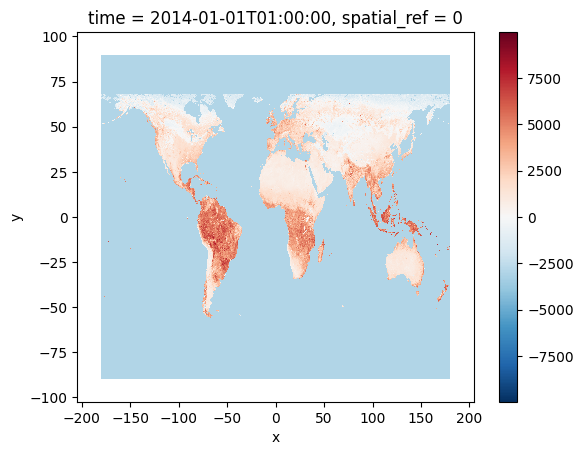

In [9]:
xr_tiles = [tile.to_xarray() for tile in tiles]
combined_tiles = xr.combine_by_coords(xr_tiles)
print(combined_tiles)
combined_tiles.plot()

In [10]:
def split_query_rect_in_two(query_rect: ge.QueryRectangle) -> Tuple[ge.QueryRectangle, ge.QueryRectangle]:
    qr_widht = query_rect.spatial_bounds.x_axis_size()
    qr_height = query_rect.spatial_bounds.y_axis_size()
    qr_half_width = qr_widht / 2
    x_min = query_rect.spatial_bounds.xmin
    y_min = query_rect.spatial_bounds.ymin
    x_max = query_rect.spatial_bounds.xmax
    y_max = query_rect.spatial_bounds.ymax

    qr_1 = ge.QueryRectangle(
        ge.BoundingBox2D(x_min, y_min, x_min + qr_half_width, y_max),
        query_rect.time,
        query_rect.spatial_resolution,
    )

    qr_2 = ge.QueryRectangle(
        ge.BoundingBox2D(x_min + qr_half_width, y_min, x_max, y_max),
        query_rect.time,
        query_rect.spatial_resolution,
    )

    return (qr_1, qr_2)

(query_rect_1, query_rect_2) = split_query_rect_in_two(query_rect)

query_rect_1, query_rect_2

(QueryRectangle( 
     BoundingBox2D(xmin=-180.0, ymin=-90.0, xmax=0.0, ymax=90.0)
     TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
     SpatialResolution(x=0.05, y=0.05)
     srs=EPSG:4326 
 ),
 QueryRectangle( 
     BoundingBox2D(xmin=0.0, ymin=-90.0, xmax=180.0, ymax=90.0)
     TimeInterval(start=2014-01-01T00:00:00.000000, end=2014-01-01T00:00:00.000000)
     SpatialResolution(x=0.05, y=0.05)
     srs=EPSG:4326 
 ))

In [11]:
s = pytime.perf_counter()

query_client_1 = client_1.workflow_as_raster_stream(client_1_wfl, query_rect_1)
query_client_2 = client_2.workflow_as_raster_stream(client_2_wfl, query_rect_2)

merged_query = stream.merge(query_client_1, query_client_2)

async with merged_query.stream() as streamer:
    tiles  = [tile async for tile in streamer]
    print(len(tiles))

elapsed = pytime.perf_counter() - s
print(f"Cell executed in {elapsed:0.2f} seconds.")

Connecting to ws://localhost:3030/api/workflow/d59770c5-7965-52cc-9e23-0c0cd4dda369/rasterStream?resultType=arrow&spatialBounds=-180.0%2C-90.0%2C0.0%2C90.0&timeInterval=2014-01-01T00%3A00%3A00.000%2B00%3A00&spatialResolution=0.05%2C0.05
Connecting to wss://internal-nightly.peter.geoengine.io/api/workflow/d59770c5-7965-52cc-9e23-0c0cd4dda369/rasterStream?resultType=arrow&spatialBounds=0.0%2C-90.0%2C180.0%2C90.0&timeInterval=2014-01-01T00%3A00%3A00.000%2B00%3A00&spatialResolution=0.05%2C0.05
128
Cell executed in 1.27 seconds.


<xarray.DataArray (y: 4096, x: 8192)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 -204.8 -204.7 -204.7 -204.6 ... 204.7 204.7 204.8
  * y            (y) float64 102.4 102.3 102.3 102.2 ... -102.3 -102.3 -102.4
    time         datetime64[ns] 2014-01-01T01:00:00
    spatial_ref  int64 0


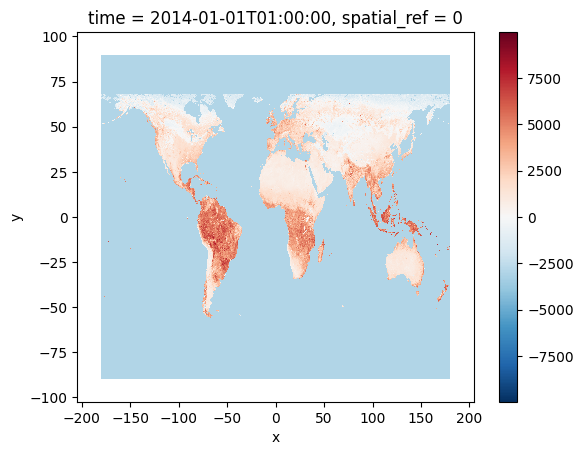

In [12]:
xr_tiles = [tile.to_xarray() for tile in tiles]
combined_tiles = xr.combine_by_coords(xr_tiles)
print(combined_tiles)
combined_tiles.plot()